SNPs matrix
========

Based on parSNP SNPs (and a parSNP tree with the outgroups removed)

<h6><a href="javascript:toggle()" target="_self">Toggle source code</a></h6>

In [3]:
# Plotting imports
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white')

In [4]:
%load_ext ipycache

In [5]:
# Other imports
import os
import pandas as pd
import numpy as np
from scipy import stats
import vcf
from Bio import SeqIO
from Bio import Phylo
from copy import deepcopy
import random

In [6]:
pfiles = {x.replace('.vcf', '')
          for x in os.listdir('../pout/')
          if x.endswith('.vcf') and not x.endswith('.nonsyn.vcf') and
          not x.endswith('.tfbs.vcf')}

In [7]:
evol = set()
for l in open('../evolution_experiment.txt'):
    evol.add(l.strip())

In [8]:
t = Phylo.read('../tout/output_restricted/parsnp.tree', 'newick')
# Max distance to create better plots
mdist = max([t.distance(t.root, x) for x in t.get_terminals()])

In [9]:
# Where is K12? Remove it as it has no SNP (obviously)
for c, i in zip(t.get_terminals(), range(len(list(t.get_terminals())))):
    if c.name == 'genome.fasta.ref':
        t.prune(c)
        continue
    c.name = c.name.replace('.fasta', '')

In [10]:
# Which genomes do we want to use for the matrix?
# Only genomes in the tree
genomes = set([x.name for x in t.get_terminals()])

In [11]:
%%cache SNPs_matrix.pkl snps
pos = {}
for f in pfiles:
    if f not in genomes:
        continue
    if '%s.vcf'%f in os.listdir('../pout'):
        for r in vcf.Reader(open('../pout/%s.vcf'%f)):
            if not r.is_indel:
                pos[ (r.POS, str(r.ALT[0])) ] = pos.get((r.POS, str(r.ALT[0])),
                                                        {})
                pos[ (r.POS, str(r.ALT[0])) ][f] = 1
snps = pd.DataFrame(pos)

[Skipped the cell's code and loaded variables snps from file '/nfs/research2/beltrao/marco/2014EColi/analysis/pangenome_variation/notebooks/SNPs_matrix.pkl'.]


In [12]:
# Missing values mean that SNP is not there
snps.replace(np.nan, 0, regex=True, inplace=True)

In [13]:
# Save it, could be useful
snpsT = snps.T
snpsT.index.names = ['position', 'alt']
snpsT.to_csv('SNPs_matrix.tsv', sep='\t')

In [14]:
# Sort table by sum of SNPs presence
# More frequent SNPs will be on the right
idx = snps.T.sum(axis=1).order(ascending=False).index
snps_sorted = snps.T.ix[idx]

In [15]:
# Remove from the tree the tips that don't have a parsnp prediction
for c in t.get_terminals():
    if c.name not in snps_sorted.columns:
        t.prune(c)

In [16]:
# Sort against the tree
snps_sorted = snps_sorted[[x.name for x in t.get_terminals()]]

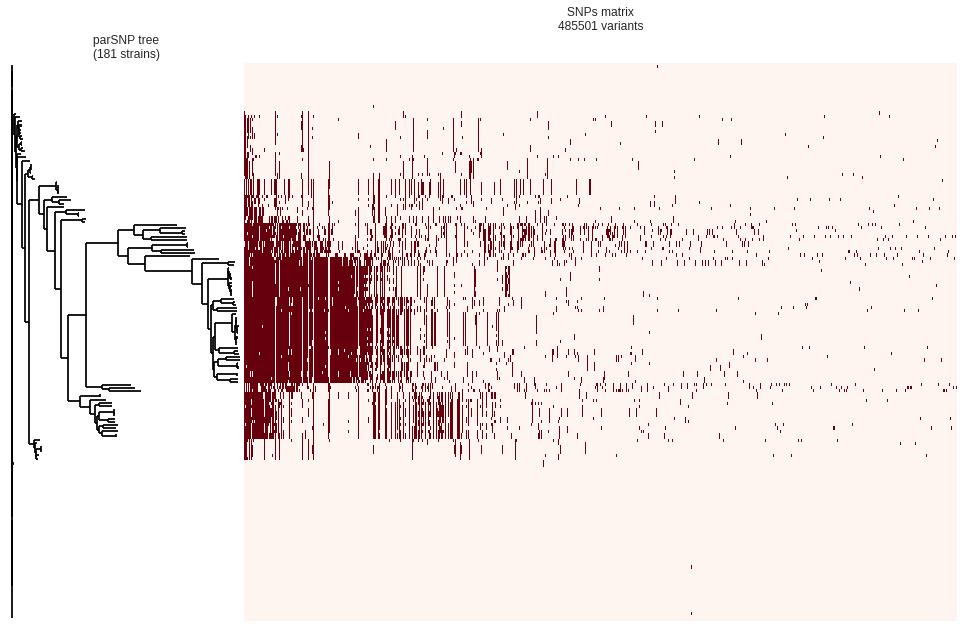

In [17]:
with sns.axes_style('whitegrid'):
    fig = plt.figure(figsize=(17, 10))

    ax1=plt.subplot2grid((1,40), (0, 10), colspan=30)
    a=ax1.matshow(snps_sorted.T, cmap=plt.cm.Reds,
               vmin=0, vmax=1,
               aspect='auto',
               #interpolation='none',
                )
    ax1.set_yticks([])
    ax1.set_xticks([])
    ax1.axis('off')

    ax = fig.add_subplot(1,2,1)
    ax=plt.subplot2grid((1,40), (0, 0), colspan=10, axisbg='white')

    fig.subplots_adjust(wspace=0, hspace=0)

    ax1.set_title('SNPs matrix\n%d variants'%snps.shape[1])

    Phylo.draw(t, axes=ax, 
               show_confidence=False,
               label_func=lambda x: None,
               xticks=([],), yticks=([],),
               ylabel=('',), xlabel=('',),
               xlim=(-0.01,mdist+0.01),
               axis=('off',),
               title=('parSNP tree\n(%d strains)'%snps.shape[0],), 
              )

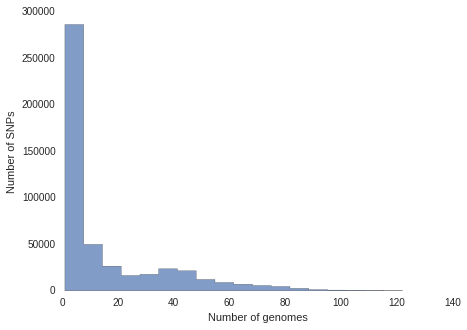

In [18]:
# Pangenome frequency plot
plt.figure(figsize=(7, 5))

plt.hist(snps.T.sum(axis=1), snps.T.shape[1]/10,
         histtype="stepfilled", alpha=.7)

plt.xlabel('Number of genomes')
plt.ylabel('Number of SNPs')

sns.despine(left=True,
            bottom=True)

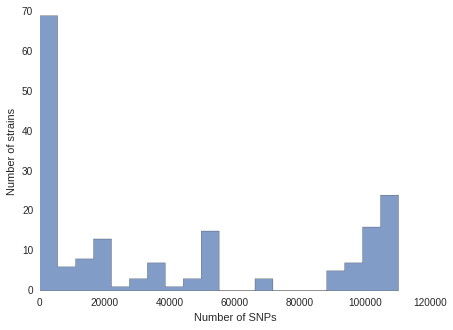

In [19]:
fig=plt.figure(figsize=(7, 5))
plt.hist(snps.T.sum(), bins=20,
        histtype="stepfilled", alpha=.7)
plt.xlabel('Number of SNPs')
plt.ylabel('Number of strains')
sns.despine(bottom=True,
            left=True)

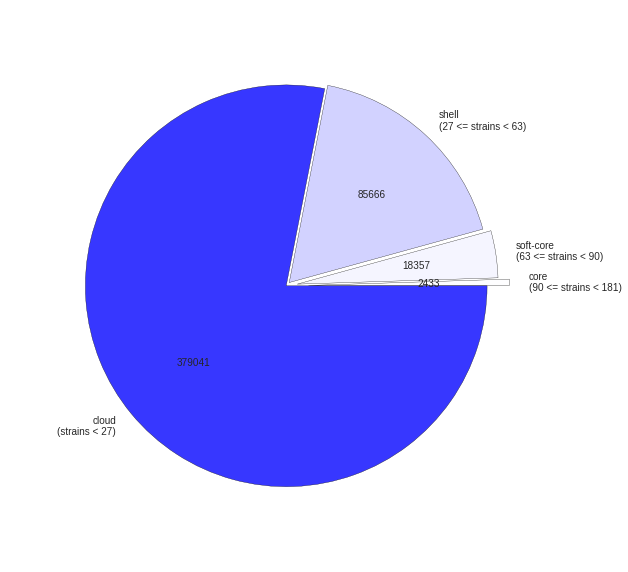

In [20]:
# Plot the panvariome pie chart
plt.figure(figsize=(10, 10))

core = snps_sorted[(snps_sorted.sum(axis=1) <= snps_sorted.shape[1]) &
                 (snps_sorted.sum(axis=1) >= snps_sorted.shape[1]*0.5)].shape[0]
softcore = snps_sorted[(snps_sorted.sum(axis=1) < snps_sorted.shape[1]*0.5) &
                 (snps_sorted.sum(axis=1) >= snps_sorted.shape[1]*0.35)].shape[0]
shell = snps_sorted[(snps_sorted.sum(axis=1) < snps_sorted.shape[1]*0.35) &
                 (snps_sorted.sum(axis=1) >= snps_sorted.shape[1]*0.15)].shape[0]
cloud = snps_sorted[snps_sorted.sum(axis=1) < snps_sorted.shape[1]*0.15].shape[0]

total = snps_sorted.shape[0]

def my_autopct(pct):
    val=int(pct*total/100.0)
    return '{v:d}'.format(v=val)

a=plt.pie([core, softcore, shell, cloud],
      labels=['core\n(%d <= strains < %d)'%(snps_sorted.shape[1]*.5,
                                                 snps_sorted.shape[1]),
              'soft-core\n(%d <= strains < %d)'%(snps_sorted.shape[1]*.35,
                                                 snps_sorted.shape[1]*.5),
              'shell\n(%d <= strains < %d)'%(snps_sorted.shape[1]*.15,
                                             snps_sorted.shape[1]*.35),
              'cloud\n(strains < %d)'%(snps_sorted.shape[1]*.15)],
      explode=[0.1, 0.05, 0.02, 0], radius=0.9,
      colors=[(0, 0, 1, float(x)/total) for x in (core, softcore, shell, cloud)],
      autopct=my_autopct)

Coding/noncoding ratios
---------------------------

In [21]:
s = SeqIO.read('../genome.gbk', 'genbank')
coding = [(int(f.location.start), int(f.location.end))
          for f in s.features
          if f.type == 'CDS' and
          'pseudo' not in f.qualifiers]

In [22]:
%%cache SNPs_matrix1.pkl cod non_cod dcoding
# What is the proportion of coding/non-coding?
cod = 0 
non_cod = 0

dcoding = {}

for x in range(1, len(s)+1):
    b = False
    for start, end in coding:
        if start <= x <= end:
            b = True
            break
    if b:
        cod += 1
        dcoding[x] = True
    else:
        non_cod += 1
        dcoding[x] = False

[Skipped the cell's code and loaded variables cod, dcoding, non_cod from file '/nfs/research2/beltrao/marco/2014EColi/analysis/pangenome_variation/notebooks/SNPs_matrix1.pkl'.]


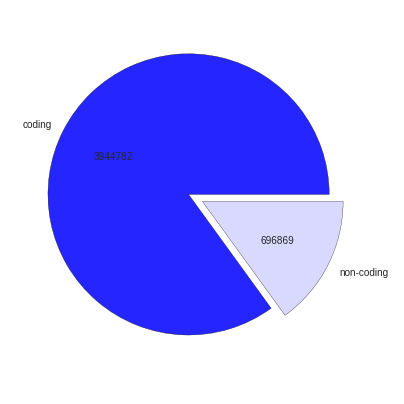

In [23]:
plt.figure(figsize=(7, 7))

total = len(s)

def my_autopct(pct):
    val=int(pct*total/100.0)
    return '{v:d}'.format(v=val)

a=plt.pie([cod, non_cod], labels=['coding', 'non-coding'],
      explode=[0.1, 0], radius=0.9,
      colors=[(0, 0, 1, float(x)/total) for x in (cod, non_cod)],
      autopct=my_autopct)

In [24]:
%%cache SNPs_matrix2.pkl coding
coding = {}
for strain in snps.index:
    coding[strain] = [0, 0]
for snp in snps.columns:
    a = snps[snp] == 1
    for strain in a[a == True].index:
        if dcoding[snp[0]]:
            coding[strain][0] += 1
        else:
            coding[strain][1] += 1

[Skipped the cell's code and loaded variables coding from file '/nfs/research2/beltrao/marco/2014EColi/analysis/pangenome_variation/notebooks/SNPs_matrix2.pkl'.]


In [25]:
# Prepare a random set
# having the same cardinality as the sample
# but with random positions in the genome
s = SeqIO.read('../genome.gbk', 'genbank')
positions = list(range(1, len(s)+1))
drandom = {}
for f in coding:
    drandom[f] = [0, 0]
    total = sum(coding[f])
    pos = [random.choice(positions) for x in range(total)]
    for i in pos:
        if dcoding[i]:
            drandom[f][0] += 1
        else:
            drandom[f][1] += 1

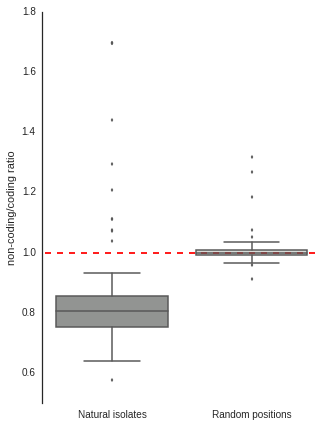

In [26]:
plt.figure(figsize=(5, 7))

sns.boxplot([[(coding[x][1]/float(non_cod))/(float(coding[x][0])/cod)
              for x in coding
              if x.split('_')[0] not in evol],
             [(drandom[x][1]/float(non_cod))/(float(drandom[x][0])/cod)
              for x in drandom
              if x.split('_')[0] not in evol]],
           names=['Natural isolates', 'Random positions'],
           color=(sns.xkcd_rgb["grey"],
                  sns.xkcd_rgb["light grey"]))

plt.hlines(1, 0, 3.5, linestyles='dashed', colors=['r'])

plt.ylabel('non-coding/coding ratio')
#plt.title('Genome non-coding/coding ratio: %.2f'%(float(non_cod)/cod))
plt.ylim(0.5, 1.8)

sns.despine(bottom=True)

Non-synonymous mutations
----------------------------

**Number of mutations Vs. species conservation**

In [27]:
ls_bsr = pd.read_table('../lreference/bsr_matrix_values.txt')

In [28]:
ls_bsr.rename(columns={ls_bsr.columns[0]:'Gene'}, inplace=True)
ls_bsr.set_index('Gene', inplace=True)

In [29]:
ls_bsr.drop([x for x in ls_bsr.columns if x.split('_')[0] in evol],
            axis=1,
            inplace=True)

In [30]:
conservation = ls_bsr.sum(axis=1)/ls_bsr.shape[1]

In [31]:
%%cache SNPs_matrix3.pkl pgenes
pgenes = {}
for f in [x for x in os.listdir('../pout/') if x.endswith('.nonsyn.vcf')]:
    if f.split('_')[0] in evol:
        continue
    pgenes[f.replace('.nonsyn.vcf', '')] = {}
    for r in vcf.Reader(open('../pout/%s'%f)):
        g = r.INFO['CDS']
        pgenes[f.replace('.nonsyn.vcf', '')][g] = pgenes[f.replace('.nonsyn.vcf', '')].get(g, 0)
        pgenes[f.replace('.nonsyn.vcf', '')][g] += 1

[Skipped the cell's code and loaded variables pgenes from file '/nfs/research2/beltrao/marco/2014EColi/analysis/pangenome_variation/notebooks/SNPs_matrix3.pkl'.]


In [32]:
%%cache SNPs_matrix4.pkl snps_nonsyn
pos = {}
for f in [x.split('.')[0] for x in os.listdir('../pout/') if x.endswith('.nonsyn.vcf')]:
    if f not in genomes:
        continue
    if '%s.nonsyn.vcf'%f in os.listdir('../pout'):
        for r in vcf.Reader(open('../pout/%s.nonsyn.vcf'%f)):
            if not r.is_indel:
                pos[ (r.POS, str(r.ALT[0])) ] = pos.get((r.POS, str(r.ALT[0])),
                                                        {})
                pos[ (r.POS, str(r.ALT[0])) ][f] = 1
snps_nonsyn = pd.DataFrame(pos)

[Skipped the cell's code and loaded variables snps_nonsyn from file '/nfs/research2/beltrao/marco/2014EColi/analysis/pangenome_variation/notebooks/SNPs_matrix4.pkl'.]


In [33]:
# Missing values mean that SNP is not there
snps_nonsyn.replace(np.nan, 0, regex=True, inplace=True)

In [34]:
# Sort table by sum of SNPs presence
# More frequent SNPs will be on the right
idx = snps_nonsyn.T.sum(axis=1).order(ascending=False).index
snps_nonsyn_sorted = snps_nonsyn.T.ix[idx]

In [35]:
# Sort against the tree
snps_nonsyn_sorted = snps_nonsyn_sorted[[x.name for x in t.get_terminals()]]

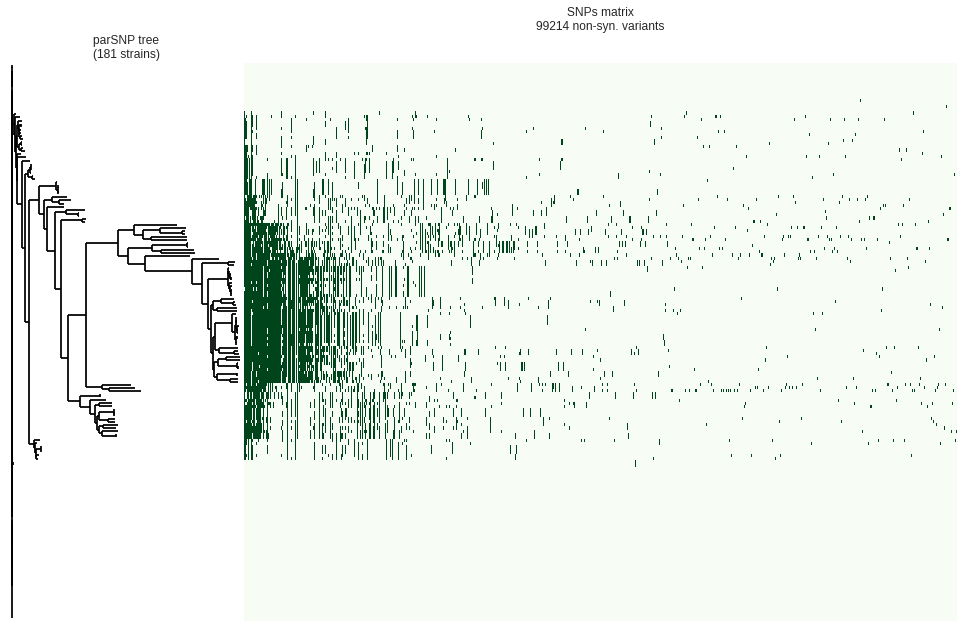

In [36]:
with sns.axes_style('whitegrid'):
    fig = plt.figure(figsize=(17, 10))

    ax1=plt.subplot2grid((1,40), (0, 10), colspan=30)
    a=ax1.matshow(snps_nonsyn_sorted.T, cmap=plt.cm.Greens,
               vmin=0, vmax=1,
               aspect='auto',
               #interpolation='none',
                )
    ax1.set_yticks([])
    ax1.set_xticks([])
    ax1.axis('off')

    ax = fig.add_subplot(1,2,1)
    ax=plt.subplot2grid((1,40), (0, 0), colspan=10, axisbg='white')

    fig.subplots_adjust(wspace=0, hspace=0)

    ax1.set_title('SNPs matrix\n%d non-syn. variants'%snps_nonsyn.shape[1])

    Phylo.draw(t, axes=ax, 
               show_confidence=False,
               label_func=lambda x: None,
               xticks=([],), yticks=([],),
               ylabel=('',), xlabel=('',),
               xlim=(-0.01,mdist+0.01),
               axis=('off',),
               title=('parSNP tree\n(%d strains)'%snps_nonsyn.shape[0],), 
              )

In [37]:
# Keep track of gene sizes for normalization
s = SeqIO.read('../genome.gbk', 'genbank')
gene_sizes = {f.qualifiers['locus_tag'][0]:int(f.location.end)-int(f.location.start)
          for f in s.features
          if f.type == 'CDS' and
          'pseudo' not in f.qualifiers}

In [38]:
pallgenes = set()
for f, v in pgenes.items():
    for g in v:
        pallgenes.add(g)

In [39]:
pvalues = []
pallvalues=[]
for g in pallgenes:
    varg = []
    for f, v in pgenes.items():
        if g in v:
            varg.append(v[g]/float(gene_sizes[g]))
    pvalues.append( (np.median(varg), conservation.loc[g]) )
    pallvalues.append(varg)

In [40]:
conserved = 0.95
muts = 0.03

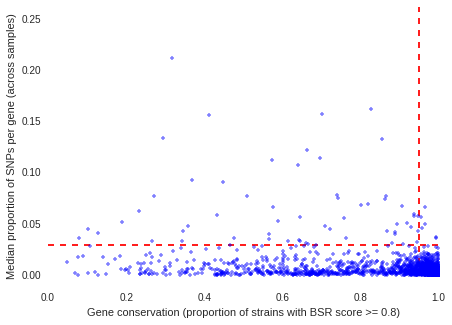

In [41]:
plt.figure(figsize=(7, 5))

plt.plot([x[1] for x in pvalues],
         [x[0] for x in pvalues],
         'b.',
         alpha=0.5)
plt.xlabel('Gene conservation (proportion of strains with BSR score >= 0.8)')
plt.ylabel('Median proportion of SNPs per gene (across samples)')

plt.hlines(muts, 0, 1, linestyles='dashed', colors=['r'])
plt.vlines(conserved, 0, max([x[0] for x in pvalues])+0.05, linestyles='dashed', colors=['r'])

plt.xlim(0, 1)
plt.ylim(-0.01, max([x[0] for x in pvalues])+0.05)
#plt.xscale('log', basex=2)
sns.despine(left=True,
            bottom=True)

In [42]:
print('Genes with lower conservation have more non-synonymous mutations (Fisher extact test)')

print('Gene is conserved if it has a BSR score >=0.8 in %.2f of the strains'%(conserved))
print('Gene is considered to have many non-synonymous mutations when they are more than %.2f'%muts+
      ' of the gene length (median across strains)')
print('')

e1 = [1 for (s, c) in pvalues if c <= conserved and s > muts]
e2 = [1 for (s, c) in pvalues if c <= conserved and s <= muts]

e3 = [1 for (s, c) in pvalues if c > conserved and s > muts]
e4 = [1 for (s, c) in pvalues if c > conserved and s <= muts]

x, p = stats.fisher_exact( [[len(e1), len(e3)],
                     [len(e2), len(e4)]],
                   alternative='greater')
print('p-value: %.2e'%p)

Genes with lower conservation have more non-synonymous mutations (Fisher extact test)
Gene is conserved if it has a BSR score >=0.8 in 0.95 of the strains
Gene is considered to have many non-synonymous mutations when they are more than 0.03 of the gene length (median across strains)

p-value: 5.40e-33


Transcription factors binding sites mutations
-----------------------------------------------------

In [43]:
%%cache SNPs_matrix5.pkl snps_tfbs
pos = {}
for f in [x.split('.')[0] for x in os.listdir('../pout/') if x.endswith('.tfbs.vcf')]:
    if f not in genomes:
        continue
    if '%s.tfbs.vcf'%f in os.listdir('../pout'):
        for r in vcf.Reader(open('../pout/%s.tfbs.vcf'%f)):
            if not r.is_indel:
                pos[ (r.POS, str(r.ALT[0])) ] = pos.get((r.POS, str(r.ALT[0])),
                                                        {})
                pos[ (r.POS, str(r.ALT[0])) ][f] = 1
snps_tfbs = pd.DataFrame(pos)

[Skipped the cell's code and loaded variables snps_tfbs from file '/nfs/research2/beltrao/marco/2014EColi/analysis/pangenome_variation/notebooks/SNPs_matrix5.pkl'.]


In [44]:
# Missing values mean that SNP is not there
snps_tfbs.replace(np.nan, 0, regex=True, inplace=True)

In [45]:
# Sort table by sum of SNPs presence
# More frequent SNPs will be on the right
idx = snps_tfbs.T.sum(axis=1).order(ascending=False).index
snps_tfbs_sorted = snps_tfbs.T.ix[idx]

In [46]:
# Remove from the tree the tips that don't have a parsnp prediction
t1 = deepcopy(t)
for c in t1.get_terminals():
    if c.name not in snps_tfbs_sorted.columns:
        t1.prune(c)

In [47]:
# Sort against the tree
snps_tfbs_sorted = snps_tfbs_sorted[[x.name for x in t1.get_terminals()]]

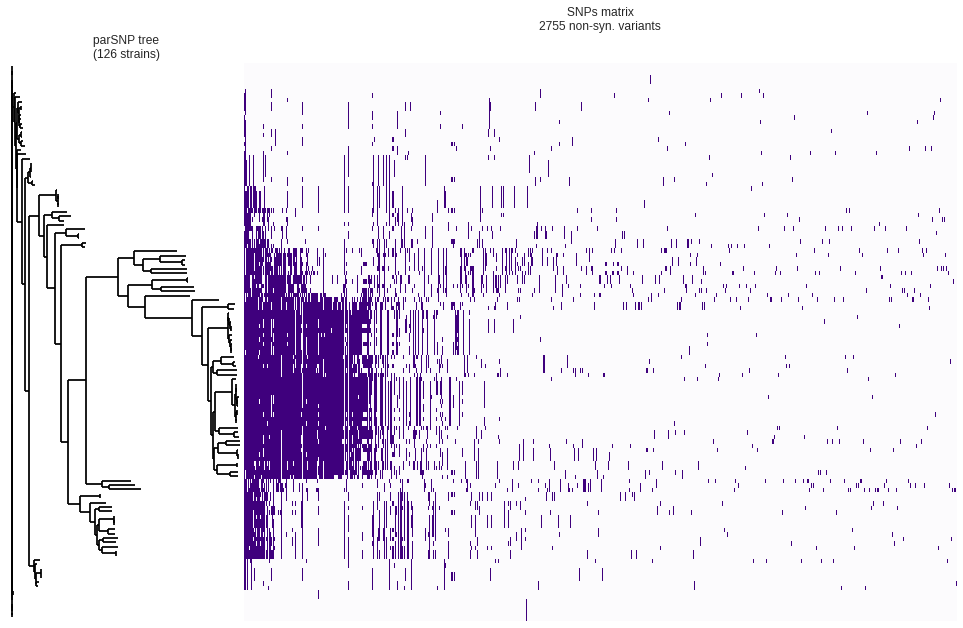

In [48]:
with sns.axes_style('whitegrid'):
    fig = plt.figure(figsize=(17, 10))

    ax1=plt.subplot2grid((1,40), (0, 10), colspan=30)
    a=ax1.matshow(snps_tfbs_sorted.T, cmap=plt.cm.Purples,
               vmin=0, vmax=1,
               aspect='auto',
               #interpolation='none',
                )
    ax1.set_yticks([])
    ax1.set_xticks([])
    ax1.axis('off')

    ax = fig.add_subplot(1,2,1)
    ax=plt.subplot2grid((1,40), (0, 0), colspan=10, axisbg='white')

    fig.subplots_adjust(wspace=0, hspace=0)

    ax1.set_title('SNPs matrix\n%d non-syn. variants'%snps_tfbs.shape[1])

    Phylo.draw(t1, axes=ax, 
               show_confidence=False,
               label_func=lambda x: None,
               xticks=([],), yticks=([],),
               ylabel=('',), xlabel=('',),
               xlim=(-0.01,mdist+0.01),
               axis=('off',),
               title=('parSNP tree\n(%d strains)'%snps_tfbs.shape[0],), 
              )

SNPs breakdown
-----------------

**Total**

In [49]:
nonsyn_tfbs = len(set(snps_tfbs.columns).intersection(set(snps_nonsyn.columns)))
nonsyn = len(set(snps_nonsyn.columns) - set(snps_tfbs.columns))
tfbs = len(set(snps_tfbs.columns) - set(snps_nonsyn.columns))
other = set(snps.columns) - set(snps_nonsyn.columns) - set(snps_tfbs.columns)
synonymous = len({x for x in other if dcoding[x[0]] is True})
non_coding = len({x for x in other if dcoding[x[0]] is False})
total = tfbs + nonsyn + nonsyn_tfbs + len(other)

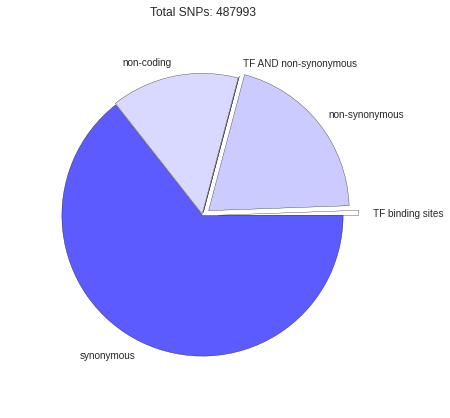

In [50]:
plt.figure(figsize=(7, 7))

def my_autopct(pct):
    val=int(pct*total/100.0)
    return '{v:d}'.format(v=val)

a=plt.pie([tfbs, nonsyn, nonsyn_tfbs, non_coding, synonymous],
          labels=['TF binding sites', 'non-synonymous',
                  'TF AND non-synonymous',
                  'non-coding', 'synonymous'],
      explode=[0.1, 0.05, 0.02, 0.01, 0], radius=0.9,
      colors=[(0, 0, 1, float(x)/total) for x in (tfbs, nonsyn,
                                                  nonsyn_tfbs,
                                                  non_coding, synonymous)],
      #autopct=my_autopct)
      )
plt.title('Total SNPs: %d'%total)
pass

**Per strain (excluding evol. experiments)**

In [51]:
nonsyn_tfbs = []
nonsyn = []
tfbs = []
other = []
synonymous = []
non_coding = []
for strain in snps.index:
    if strain.split('_')[0] in evol:
        continue
    n = {(x[0], x[1]) for x in snps_nonsyn[snps_nonsyn == 1].loc[strain].dropna().index}
    if strain not in snps_tfbs.index:
        t = set()
        n_t = set()
    else:
        t = {(x[0], x[1]) for x in snps_tfbs[snps_tfbs == 1].loc[strain].dropna().index}
        n_t = n.intersection(t)
    n = n - t
    t = t - n
    o = {(x[0], x[1]) for x in snps[snps == 1].loc[strain].dropna().index} - t - n
    s = {x for x in o if dcoding[x[0]] is True}
    nc = {x for x in o if dcoding[x[0]] is False}
    
    nonsyn_tfbs.append( len(n_t) )
    nonsyn.append( len(n) )
    tfbs.append( len(t) )
    other.append( len(o) )
    synonymous.append( len(s) )
    non_coding.append( len(nc) )

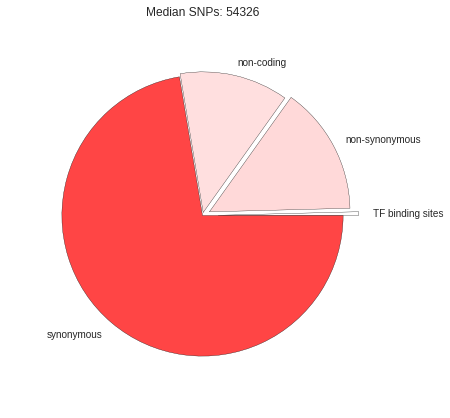

In [52]:
plt.figure(figsize=(7, 7))

n_t = np.median(nonsyn_tfbs)
n = np.median(nonsyn)
t = np.median(tfbs)
o = np.median(other)
s = np.median(synonymous)
nc = np.median(non_coding)
total = n_t + n + t + s + nc

def my_autopct(pct):
    val=int(pct*total/100.0)
    return '{v:d}'.format(v=val)

a=plt.pie([t+n_t, n, nc, s],
          labels=['TF binding sites', 'non-synonymous',
                  'non-coding', 'synonymous'],
      explode=[0.1, 0.05, 0.02, 0], radius=0.9,
      colors=[(1, 0, 0, float(x)/total) for x in (t+n_t, n, nc, s)],
      #autopct=my_autopct)
      )
plt.title('Median SNPs: %d'%total)
pass

In [53]:
%%cache SNPs_functional.pkl snps_functional
# Save all "functional" SNPs
pos = {}
for f in [x.split('.')[0] for x in os.listdir('../pout/') if x.endswith('.nonsyn.vcf')]:
    if f not in genomes:
        continue
    if '%s.nonsyn.vcf'%f in os.listdir('../pout'):
        for r in vcf.Reader(open('../pout/%s.nonsyn.vcf'%f)):
            if not r.is_indel:
                pos[ (r.POS, str(r.ALT[0])) ] = pos.get((r.POS, str(r.ALT[0])),
                                                        {})
                pos[ (r.POS, str(r.ALT[0])) ][f] = 1
for f in [x.split('.')[0] for x in os.listdir('../pout/') if x.endswith('.tfbs.vcf')]:
    if f not in genomes:
        continue
    if '%s.tfbs.vcf'%f in os.listdir('../pout'):
        for r in vcf.Reader(open('../pout/%s.tfbs.vcf'%f)):
            if not r.is_indel:
                pos[ (r.POS, str(r.ALT[0])) ] = pos.get((r.POS, str(r.ALT[0])),
                                                        {})
                pos[ (r.POS, str(r.ALT[0])) ][f] = 1
snps_functional = pd.DataFrame(pos)

[Saved variables snps_functional to file '/nfs/research2/beltrao/marco/2014EColi/analysis/pangenome_variation/notebooks/SNPs_functional.pkl'.]


In [54]:
# Missing values mean that SNP is not there
snps_functional.replace(np.nan, 0, regex=True, inplace=True)

In [55]:
# Save it, could be useful
snps_functionalT = snps_functional.T
snps_functionalT.index.names = ['position', 'alt']
snps_functionalT.to_csv('SNPs_functional_matrix.tsv', sep='\t')